In [1]:
import pandas as pd
import os
from tqdm import tqdm
from utils import avg, evidence_to_mask

def to_data_df(df, data_dir):
    data_df = []
    columns = ['text', 'classification', 'rationale', 'query']
    for i in tqdm(range(len(df))):
        df_row = df.loc[i]
        text_id = df_row['annotation_id']
        idx = text_id.find('txt')
        text_id = text_id[:idx+3]
        query = df_row['query']
        evidence_list = df_row['evidences']
        if evidence_list:
            evidence_list = [x for xx in evidence_list for x in xx]
        classification = df_row['classification']
        
        file = f'{data_dir}/docs/{text_id}'
        if os.path.isfile(file):
            f = open(file, 'r', encoding="utf-8") 
            text = ''
            for line in f.readlines():
                text += line.rstrip() + ' '
        else:
            print("???")      
        
        tokens = text.split()
        rationale_mask = evidence_to_mask(tokens, evidence_list)
        
######## THIS WORKS!!!!!!!!!##############
#         query = query.replace("||","[SEP]")
#         QA = f"{text} {query}"
#         rationale_mask = rationale_mask + [1]*(len(query.split())+1)
        
        query = query.split("||")
        QA = f"{text} {query[0]}"
#         rationale_mask = rationale_mask + [1]*(len(query.split())+1)
        
        data_df.append([QA, classification, rationale_mask, query[1]])
    data_df = pd.DataFrame(data_df, columns=columns)
    return data_df

In [2]:
dataset = "multirc"

In [3]:
data_dir = f'../data/{dataset}'
train = pd.read_json(f'{data_dir}/train.jsonl', lines=True)
test = pd.read_json(f'{data_dir}/test.jsonl', lines=True)
val = pd.read_json(f'{data_dir}/val.jsonl', lines=True)

In [5]:
train_data_df = to_data_df(train, data_dir)
# train_data_df.to_csv(f"{dataset}/train.csv",index_label="id")
test_data_df = to_data_df(test, data_dir)
# test_data_df.to_csv(f"{dataset}/test.csv",index_label="id")
val_data_df = to_data_df(val, data_dir)
# val_data_df.to_csv(f"{dataset}/val.csv",index_label="id")

 19%|██████████████▎                                                            | 4604/24029 [00:03<00:13, 1417.12it/s]


KeyboardInterrupt: 

# SANITY CHECK

In [13]:
def rationale_check(text,rationale):
    tokens = text.split()
    out = ""
    for i, b in enumerate(rationale):
        if b:
           out += tokens[i] + " "
    return out

In [38]:
data_df = test_data_df
import json

def reduce_by_alpha(text, rationale, fidelity_type="sufficiency"):
    reduced_text = ""
    # whitespace tokenization
    tokens = text.split()

    for idx in range(len(tokens)):
        try:
            if fidelity_type == "sufficiency" and rationale[idx] >= 0.5:
                reduced_text = reduced_text + tokens[idx] + " "
            elif fidelity_type == "comprehensiveness" and rationale[idx] < 0.5:
                reduced_text = reduced_text + tokens[idx] + " "
        except Exception as e:
            if fidelity_type == "comprehensiveness":
                reduced_text = reduced_text + tokens[idx] + " "

    # removed the last space from the text
    if len(reduced_text) > 0:
        reduced_text = reduced_text[:-1]

    return reduced_text

data_df = data_df[data_df['rationale'].notna()]
data_df.reset_index(drop=True, inplace=True)


data_df["sufficiency_text"] = data_df[
    ["text", "rationale"]].apply(lambda s: reduce_by_alpha(*s, fidelity_type="sufficiency"), axis=1)
data_df["comprehensiveness_text"] = data_df[
    ["text", "rationale"]].apply(lambda s: reduce_by_alpha(*s, fidelity_type="comprehensiveness"), axis=1)

In [14]:
rationale_check(train_data_df.iloc[2]['text'],train_data_df.iloc[2]['rationale'])

'It was these same impulses , leading so invariably to success , that made his enemies call him the Wisest Man . He leaned forward and touched the chauffeur \'s shoulder . " Stop at the Court of General Sessions , " he commanded . A word , a personal word from him to the district attorney , or the judge , would be enough . '

In [18]:
train['evidences'][2]

[[{'docid': 'Fiction-stories-masc-A_Wasted_Day-2.txt',
   'end_sentence': 16,
   'end_token': 349,
   'start_sentence': 15,
   'start_token': 327,
   'text': 'It was these same impulses , leading so invariably to success , that made his enemies call him the Wisest Man .'},
  {'docid': 'Fiction-stories-masc-A_Wasted_Day-2.txt',
   'end_sentence': 17,
   'end_token': 359,
   'start_sentence': 16,
   'start_token': 349,
   'text': "He leaned forward and touched the chauffeur 's shoulder ."},
  {'docid': 'Fiction-stories-masc-A_Wasted_Day-2.txt',
   'end_sentence': 18,
   'end_token': 372,
   'start_sentence': 17,
   'start_token': 359,
   'text': '" Stop at the Court of General Sessions , " he commanded .'},
  {'docid': 'Fiction-stories-masc-A_Wasted_Day-2.txt',
   'end_sentence': 20,
   'end_token': 405,
   'start_sentence': 19,
   'start_token': 384,
   'text': 'A word , a personal word from him to the district attorney , or the judge , would be enough .'}]]

# DATA STATS

In [6]:
def generate_class_stats(train_df, test_df, val_df):
    text_lens_0 = []
    text_lens_1 = []
    rationale_lens_0 = []
    rationale_lens_1 = []
    rationale_percent_0 = []
    rationale_percent_1 = []
    class_distribution = [0,0]
    for df in [train_df, test_df, val_df]:
        for i in range(len(df)):
            df_row = df.loc[i]
            clas = df_row['classification']
            text = df_row['text']
            rationale = df_row['rationale']
            query = df_row['query']
            
            query_len = len(query.split())
            text_len = len(text.split())
            rationale_len = rationale.count(1)
            rationale_percent = rationale_len/text_len
            if clas == "False":
                text_lens_0.append(text_len)
                rationale_lens_0.append(rationale_len)
                rationale_percent_0.append(rationale_percent)
                class_distribution[0] += 1
            else:
                text_lens_1.append(text_len)
                rationale_lens_1.append(rationale_len)
                rationale_percent_1.append(rationale_percent)
                class_distribution[1] += 1
                
    all_stats = {"text_lens_0": text_lens_0,
                 "text_lens_1": text_lens_1,
                 "text_lens_all":text_lens_0 + text_lens_1,
                 "rationale_lens_0":rationale_lens_0,
                 "rationale_lens_1":rationale_lens_1,
                 "rationale_lens_all":rationale_lens_0 + rationale_lens_1,
                 "rationale_percent_0": rationale_percent_0,
                 "rationale_percent_1": rationale_percent_1,
                 "rationale_percent_all": rationale_percent_0 + rationale_percent_1,
                 "class_distr":[class_distribution[0]/sum(class_distribution),class_distribution[1]/sum(class_distribution)]
                }
    return all_stats

In [10]:
all_stats = generate_class_stats(train_data_df,test_data_df,val_data_df)
for key,value in all_stats.items():
    print(f"{key}: {avg(value)}")
print(all_stats["class_distr"])

text_lens_0: 318.45183702962595
text_lens_1: 310.77560283687944
text_lens_all: 315.0790875946527
rationale_lens_0: 50.528708798843866
rationale_lens_1: 50.67531914893617
rationale_lens_all: 50.593125798510485
rationale_percent_0: 0.16558116676322926
rationale_percent_1: 0.16995819701331757
rationale_percent_all: 0.16750432673101273
class_distr: 0.5
[0.5606244741516313, 0.4393755258483687]


In [12]:
val_data_df.iloc[0]['text']

'Allan sat down at his desk and pulled the chair in close . Opening a side drawer , he took out a piece of paper and his inkpot . After filling his pen , Allan looked at his paper in the orange glow from the lantern set back in the desk \'s right - hand corner . His pen cast a forbidding line of shadow slanting across the page , echoing the inky darkness crouching in the edges of the lantern \'s struggling glow . The only other illumination came from a lurid moonlight filtered through thin branches and clouds , casting its bone - pale glow onto the pine floorboards . Allan unfolded another page , this one crowded with ranks of letters in tight formation from left to right . The lines of letters stepped into their divisions , in the shape of a story \'s outline : the loose , dry skeleton of a tale lay exposed beneath their feet , awaiting tendons , muscle and blushing skin . Allan reviewed the troops , all prepared to disembark , their task to form the tale of a young man returning home

In [24]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   annotation_id   3214 non-null   object 
 1   classification  3214 non-null   object 
 2   docids          0 non-null      float64
 3   evidences       3214 non-null   object 
 4   query           3214 non-null   object 
 5   query_type      0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 150.8+ KB


In [6]:
train = pd.read_csv(f"{dataset}/train.csv")

In [7]:
t = list(train['text'])

In [17]:
li = [len(x.split()) for x in t]

In [25]:
def text_len_scatter(train, test, val):
    all_texts = list(train['text']) + list(test['text']) + list(val['text'])
    all_text_lens = [len(x.split()) for x in all_texts]
    count_dict = {}
    for text_len in all_text_lens:
        if text_len not in count_dict.keys():
            count_dict[text_len] = 1
        else:
            count_dict[text_len] += 1
    import matplotlib.pyplot as plt
    plt.scatter(list(count_dict.keys()),list(count_dict.values()))

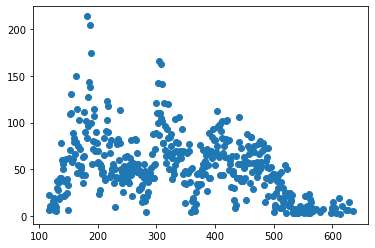

In [24]:
text_len_scatter